In [1]:
import os 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
store_sales = pd.read_csv('~/Desktop/Tasks(AI).Append/Sales-Forecast-data-csv-main/train.csv')
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [6]:
store_sales.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
store_sales = store_sales.drop(['store', 'item'], axis=1)

## converte the datatype

In [8]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [9]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [10]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [11]:
##convert the datatype to timestamp
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [12]:
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


## visualization

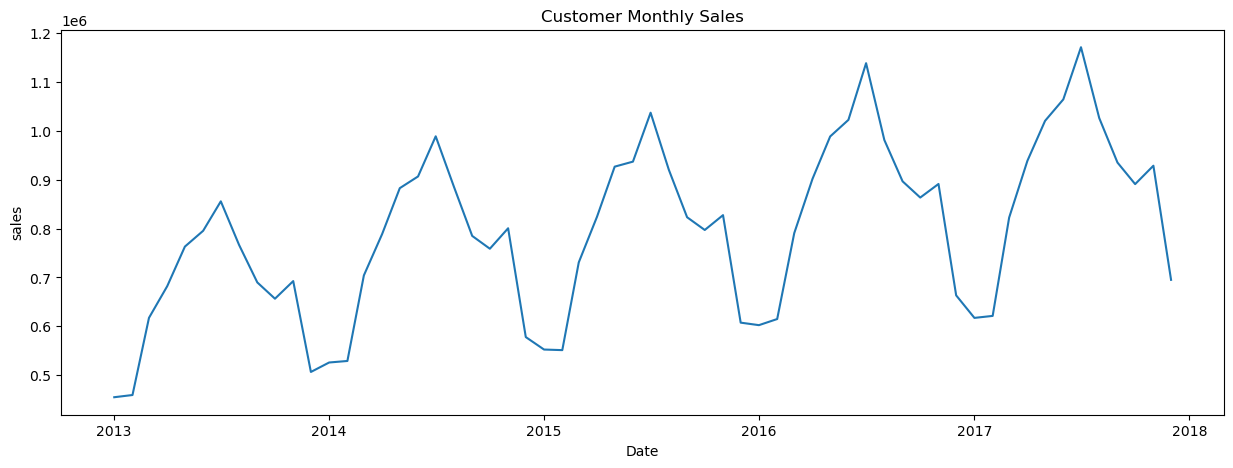

In [13]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title('Customer Monthly Sales')
plt.show()

## make the data stationly

In [14]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


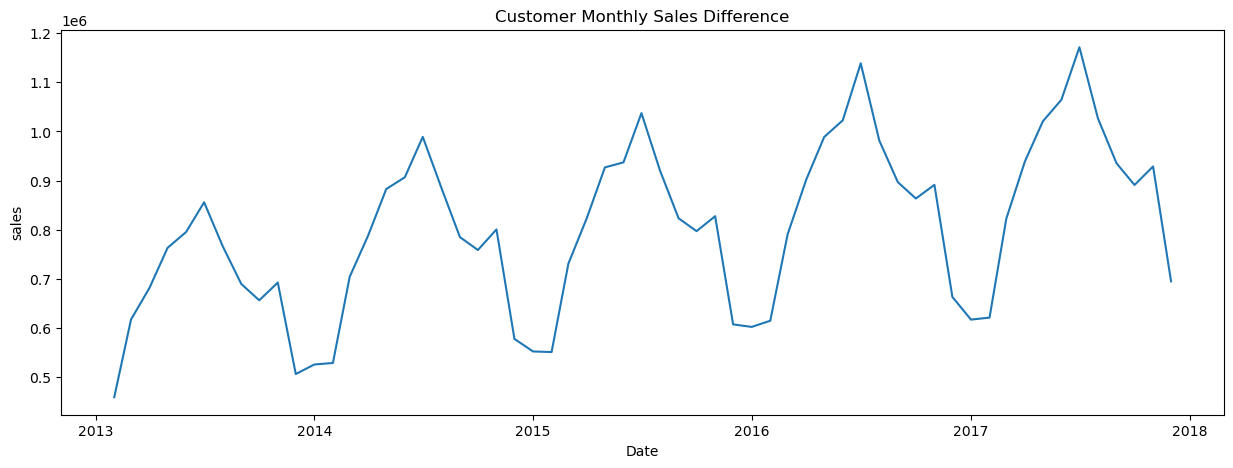

In [15]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title('Customer Monthly Sales Difference')
plt.show()

In [16]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

#### preparing the supervised data

In [17]:
for i in range(1, 13):
    col_name = 'month' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


## Train and test data

In [18]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print('Train data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Train data shape:  (35, 13)
Test data shape:  (12, 13)


In [19]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [20]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (35, 12)
x_test shape:  (12, 12)
y_train shape:  (35,)
y_test shape:  (12,)


## prediction dataframe 

In [21]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [22]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


## linear model & prediction

In [28]:
model = LinearRegression()
model.fit(x_train,x_train)
lr_pre = model.predict(x_test)

In [33]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 144 and the array at index 1 has size 12

In [26]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0]+act_sales[index])
    
lr_pre_series = pd.Series(result_list, name='Linear Prediction')
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

NameError: name 'lr_pre_test_set' is not defined

In [ ]:
## mean sqrt error
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
## mean abs error
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
## r2 score error
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print('Linear Regression MSE: ', lr_mse)
print('Linear Regression MAE: ', lr_mae)
print('Linear Regression R2: ', lr_r2)

In [ ]:
plt.figure(figsize=(15,5))
# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
#Predicted sales
plt.plot(predict_df.['date'], predict_df['Linear Prediction'])
plt.title("Customer sales forcast using LR Model")
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(["Actual Sales", "Predicted Sales"])
plt.show()